<a href="https://colab.research.google.com/github/LilachPardess/final-rl-project-minigrid/blob/main/Final_Project_RL_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎮 Deep RL Final Project — MiniGrid Environments

## Overview
In this project, you will train deep RL agents on two MiniGrid environments. You must implement the core algorithms yourself using concepts from class.

**Read first:** Follow the instructions in the accompanying PDF. This notebook defines the environment APIs and where you may edit.

## Learning objectives
- Implement deep RL from scratch.
- Design observation preprocessing and reward shaping.
- Evaluate performance with clear metrics and plots.
- Communicate results in a concise report.

## 🌍 The Two Environments
| Environment | Description | Actions | Goal |
|-------------|-------------|---------|------|
| **`SimpleGridEnv`** | 8×8 empty room | 3 (Left, Right, Forward) | Navigate to the green goal square |
| **`KeyDoorBallEnv`** | Two rooms with locked door | 5 (Left, Right, Forward, Pickup, Toggle) | Get key → Open door → Pick up ball → Reach goal |

## ✅ What You CAN Modify
- **Preprocessing** — Implement your own observation preprocessing function.
- **Reward shaping** — Modify rewards in each `step()` method (see `# TODO`).
- **Observation space** — Update `self.observation_space` to match preprocessing output.

## ❌ What You CANNOT Modify
- Grid layout and generation logic.
- Action spaces or termination conditions.
- Environment mechanics (door/key/ball rules).
- **No external RL libraries** for the core algorithm (you may use PyTorch/TensorFlow).

## 📦 Deliverables & Submission
**Submit:** (1) this notebook with your full code and outputs, and (2) a report formatted **as specified in the instructions PDF**.

## 🧪 Reproducibility checklist
- Set random seeds for Python, NumPy, and your DL framework.
- Document hyperparameters.

## 🧾 Academic integrity
- You may discuss ideas, but code and write-up must be your own.
- Cite any external resources (blog posts, papers, code snippets).
---

# Setup

## Installs and Imports

### Installs (run once if needed)

In [36]:
%%capture
#!sudo apt-get update
#!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install imageio
!pip install pyvirtualdisplay
!pip install gymnasium
!pip install minigrid
!pip install pygame

### Imports

In [37]:
# 1. Future Imports (Must be first)
from __future__ import annotations

# 2. Standard Library Imports
import base64
import copy
import random
from collections import deque

# 3. Third-Party Data & Visualization Imports
import imageio
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import HTML
import pyvirtualdisplay

# 4. Gymnasium Imports
import gymnasium as gym
from gymnasium import spaces

# 5. Minigrid Imports
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Lava, Wall, Ball
from minigrid.minigrid_env import MiniGridEnv as BaseMiniGridEnv

# --- Configuration ---

# Configure Matplotlib for Notebook Environment
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Display utils
The cell below contains the video display configuration. No need to make changes here.

In [38]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# Xvfb is Linux-only (e.g. Colab). On macOS, skip virtual display.
import sys
if sys.platform == "linux":
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
else:
    display = None  # macOS: use default display

# Environments

> ⚠️ **Important**
>
> The two environments below are **fixed**—do not modify grid layout, action spaces, or termination conditions.
>
> **You may modify only:**
> 1. **Observation space** — set `self.observation_space` to match your preprocessing output (see `# TODO`).
> 2. **Reward shaping** — edit reward logic inside `step()` (see `# TODO`).
>
> Look for the clearly marked sections in each environment class.

In [39]:
# =============================================================================
# ENVIRONMENT 1: SIMPLE GRID (Empty Room)
# =============================================================================
class SimpleGridEnv(BaseMiniGridEnv):
    """
    A simple grid environment with no obstacles inside, just outer walls.
    The agent and goal positions are randomized at each reset.

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        preprocess=None,
        **kwargs,
    ):

        # Define a static mission string (not used by the agent typically)
        mission_space = MissionSpace(mission_func=self._gen_mission)


        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )
        # Discrete actions: 0: Turn Left, 1: Turn Right, 2: Move Forward
        self.action_space = spaces.Discrete(3)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(84, 84, 3),
            dtype=np.float32
        )
        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # Preprocessing function for observations
        self.preprocess = preprocess if preprocess is not None else lambda x: x
        self.walls_init = []
        # Default goal and agent starting position (overwritten in _gen_grid)
        self.goal_pos = (self.width - 2, self.height - 2)
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0


    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # 1. Randomize agent starting parameters before generating the grid
        self.agent_start_pos = (random.randint(1, 6), random.randint(1, 6))
        self.agent_start_dir = random.choice([0, 1, 2, 3])
        # 2. Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)
        # 3. Return the preprocessed observation
        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Procedurally generates the grid layout: walls, goal, and agent."""
        self.grid = Grid(width, height)

        # 1. Create the outer boundary walls
        self.grid.wall_rect(0, 0, width, height)

        # 2. Place internal walls (if any defined in self.walls_init)
        for column, row in self.walls_init:
            self.grid.set(column, row, Wall())

        # 3. Randomize Goal Position (Top-Right, Bottom-Right, Bottom-Left corners roughly)
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 4. Place Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

        self.mission = "grand mission"

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Standard step function.

        Current reward scheme (sparse):
            - +1.0 when reaching the goal (terminated=True)
            - 0.0 otherwise

        💡 You can add reward shaping here
        """
        obs, reward, terminated, truncated, info = super().step(action)

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 1.0
        else:
            reward = -0.001
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

In [40]:
# =============================================================================
# ENVIRONMENT 2: KEY-DOOR WITH BALL PICKUP
# =============================================================================
class KeyDoorBallEnv(BaseMiniGridEnv):
    """
    Grid environment with two rooms separated by a locked door.

    Task sequence:
        1. Pick up key -> 2. Unlock door -> 3. Pick up ball -> 4. Reach goal

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
        3: Pick Up
        4: Toggle (open/close door)
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        partition_col=3,
        require_ball_pickup=True,
        preprocess=None,
        **kwargs,
    ):
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0
        self.partition_col = partition_col
        self.walls_init = []
        self.inventory = []
        self.require_ball_pickup = require_ball_pickup
        self.preprocess = preprocess if preprocess is not None else lambda x: x

        mission_space = MissionSpace(mission_func=self._gen_mission)
        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )

        # 5 actions: left, right, forward, pickup, toggle
        self.action_space = spaces.Discrete(5)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(84, 84, 3),
            dtype=np.float32
        )
        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # State tracking for reward shaping (you can use these in your reward logic)
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "Pick up the key to open the door, pick up the ball, then reach the goal"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # Reset state tracking
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False
        self.inventory = []

        # Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)

        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Generate grid: walls, partition, door, key, ball, goal, agent."""
        # Grid with outer walls
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)

        # Partition wall
        self.walls_init = [(self.partition_col, i) for i in range(height)]
        for col, row in self.walls_init:
            if 0 <= col < width and 0 <= row < height:
                self.grid.set(col, row, Wall())

        # Key in left room
        self.key_pos = (
            random.choice(range(1, self.partition_col)),
            random.choice(range(2, height - 1))
        )
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))

        # Door in partition
        door_y = random.choice(range(1, height - 1))
        self.door_pos = (self.partition_col, door_y)
        self.env_door = Door(COLOR_NAMES[0], is_locked=True)
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)

        # Goal
        self.goal_pos = (8, 8)
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Ball in right room (if required)
        if self.require_ball_pickup:
            right_x = range(self.partition_col + 2, width - 2)
            right_y = range(1, height - 1)
            while True:
                ball_x = random.choice(list(right_x))
                ball_y = random.choice(list(right_y))
                self.ball_pos = (ball_x, ball_y)
                if self.ball_pos != self.goal_pos:
                    break

            self.grid.set(ball_x, ball_y, Ball(COLOR_NAMES[1]))

        # Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

    def try_pickup_ball(self):
        """Pick up ball in front and add to inventory."""
        obj = self.grid.get(self.front_pos[0], self.front_pos[1])
        if isinstance(obj, Ball):
            self.grid.set(self.front_pos[0], self.front_pos[1], None)
            self.inventory.append(obj)

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Step function with sparse reward.

        Available helper methods for reward shaping:
            - self.is_carrying_key()  : Returns True if agent has the key
            - self.is_carrying_ball() : Returns True if agent has the ball
            - self.is_door_open()     : Returns True if door is open
            - self.prev_key           : Key status before this step
            - self.prev_door          : Door status before this step
            - self.prev_ball          : Ball status before this step

        Current reward scheme (sparse):
            - +1.0 for reaching goal with ball
            - 0.0 otherwise

        💡 You can add reward shaping here
        """
        # Map action 4 to toggle (internal MiniGrid uses 5 for toggle)
        if action == 4:
            action = 5

        # Track previous state for reward shaping
        self.prev_key = self.is_carrying_key()
        self.prev_door = self.is_door_open()
        self.prev_ball = self.is_carrying_ball()

        # Handle ball pickup
        if action == 3:
            self.try_pickup_ball()

        # Standard step
        obs, reward, terminated, truncated, info = super().step(action)

        # Goal only counts if ball is picked up (when required)
        terminated = terminated and (not self.require_ball_pickup or self.is_carrying_ball())

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 1.0
        else:
            reward = 0.0
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: State getter methods (use these in reward shaping)   ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    def is_carrying_key(self):
        """Check if agent has key (in hand or inventory)."""
        key_in_hand = self.carrying and isinstance(self.carrying, Key)
        key_in_inventory = any(isinstance(item, Key) for item in self.inventory)
        return key_in_hand or key_in_inventory

    def is_carrying_ball(self):
        """Check if agent has ball (in hand or inventory)."""
        ball_in_hand = self.carrying and isinstance(self.carrying, Ball)
        ball_in_inventory = any(isinstance(item, Ball) for item in self.inventory)
        return ball_in_hand or ball_in_inventory

    def is_door_open(self):
        """Returns True if the door is open."""
        if hasattr(self, 'env_door'):
            return self.env_door.is_open
        return False

# Preprocessing Method

> 💡 **Student task:** Implement your own preprocessing function below.
>
> Your preprocessing function should:
> 1. Take a raw RGB image (320×320×3) as input.
> 2. Return a processed observation that **exactly matches** your `observation_space` (shape, dtype, value range).
>
> Common preprocessing techniques:
> - Crop edges to remove borders
> - Convert to grayscale
> - Resize to smaller dimensions
> - Normalize pixel values
>
> **Reminder:** Update `self.observation_space` in both environment classes to match your output.

In [41]:
# Ensure opencv-python is installed in the current kernel (run once, then re-run cell if import fails)
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "opencv-python", "-q"])

import cv2

# Example Preprocessing Function
PREPROCESS_SIZE = (84, 84)  # (height, width) — smaller = faster training, less memory

def pre_process(img):
    """
    Preprocess raw RGB observation from the environment.
    1. Copy to array
    2. Resize to smaller dimensions (e.g. 84x84) for faster training and less replay memory.
    3. Normalize pixel values to [0, 1] (divide by 255) for stable neural network training.

    Input:  RGB image (320, 320, 3), uint8 [0, 255]
    Output: RGB image (84, 84, 3), float32 [0.0, 1.0]
    """
    arr = np.array(img, copy=True)
    resized = cv2.resize(arr, (PREPROCESS_SIZE[1], PREPROCESS_SIZE[0]), interpolation=cv2.INTER_AREA)
    normalized = resized.astype(np.float32) / 255.0

    #TODO check if check use several images
    return normalized

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


# 🔍 Environment Examples & Exploration
Run the cells below to understand each environment before implementing your solution.
Use these quick tests to verify preprocessing output shape and rendering.

## Environment 1: SimpleGridEnv (Empty Room)

**Task**: Navigate to the green goal square in an empty 8×8 room.

| Property | Value |
|----------|-------|
| Grid Size | 8×8 |
| Agent Start | Random position (1-6, 1-6) |
| Agent Direction | Random (0-3) |
| Goal Position | Random: (8,1), (1,8), or (8,8) |
| Actions | 0: Turn Left, 1: Turn Right, 2: Move Forward |
| Sparse Reward | +1.0 on reaching goal, 0.0 otherwise |

### Quick Test

=== SimpleGridEnv ===
Action space:       Discrete(3)
Number of actions:  3
Observation space:  Box(0.0, 1.0, (84, 84, 3), float32)  (ensure it matches preprocessing output)
Observation shape:  (84, 84, 3)
Agent direction:    3
Agent position:     (2, 5)
Goal position:      (8, 8)


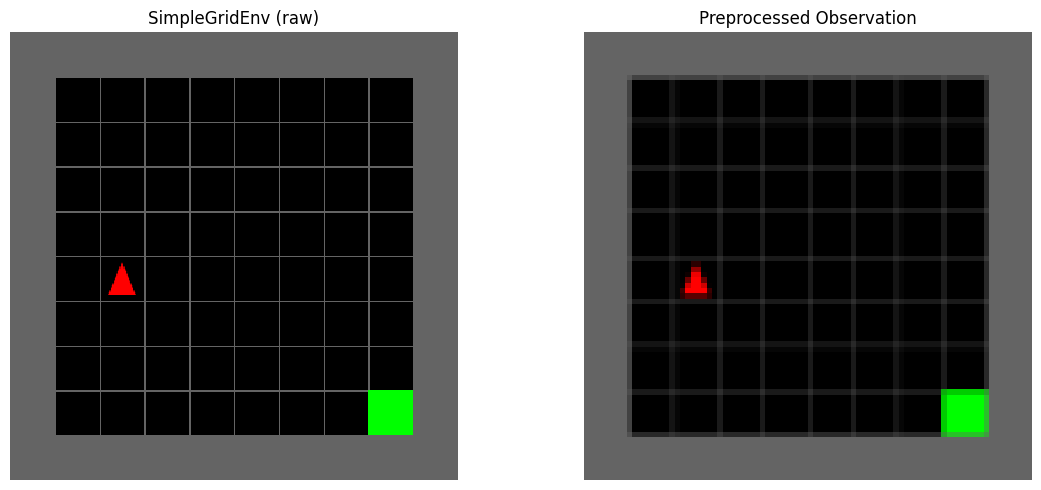

In [42]:
# Initialize environment with preprocessing
env = SimpleGridEnv(max_steps=100, preprocess=pre_process)
obs = env.reset()[0]

print("=== SimpleGridEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("SimpleGridEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

## Environment 2: KeyDoorBallEnv (Key-Door-Ball Task)

**Task**: Complete a multi-step objective: Key → Door → Ball → Goal

| Property | Value |
|----------|-------|
| Grid Size | 8×8 (two rooms) |
| Partition Wall | Column 3 |
| Key Location | Left room (random) |
| Door Location | In partition wall (random row) |
| Ball Location | Right room (random) |
| Goal Position | Fixed at (8, 8) |
| Actions | 0: Left, 1: Right, 2: Forward, 3: Pickup, 4: Toggle |

**Sequence**: Pick up key → Open door → Enter right room → Pick up ball → Reach goal

**Helper Methods** (use in reward shaping):
- `is_carrying_key()` — True if agent has the key
- `is_carrying_ball()` — True if agent has the ball
- `is_door_open()` — True if door is open

### Quick Test

=== KeyDoorBallEnv ===
Action space:       Discrete(5)
Number of actions:  5
Observation space:  Box(0.0, 1.0, (84, 84, 3), float32)  (ensure it matches preprocessing output)
Observation shape:  (84, 84, 3)
Agent direction:    0
Agent position:     (1, 1)
Goal position:      (8, 8)
Carrying key:       False
Door open:          False
Carrying ball:      False


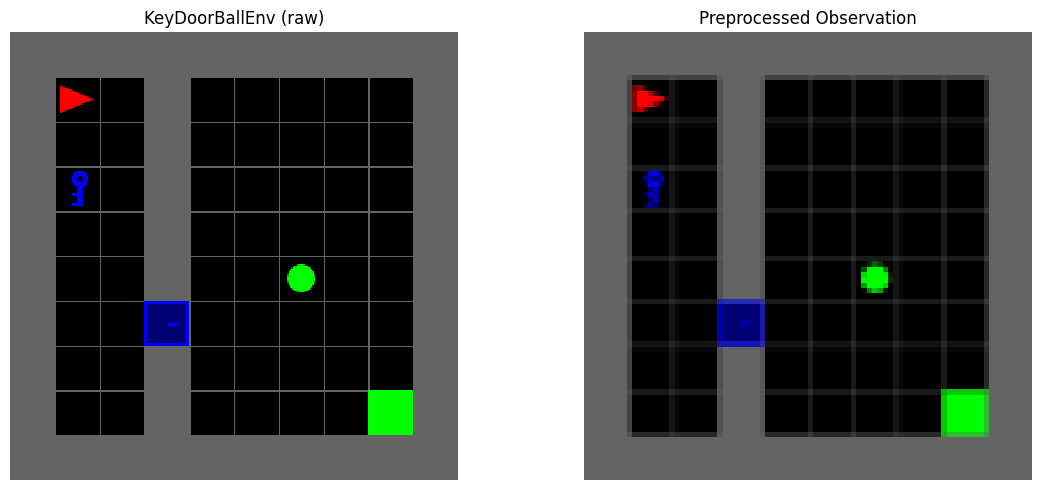

In [43]:
# Initialize environment
env = KeyDoorBallEnv(max_steps=5000, preprocess=pre_process)
obs = env.reset()[0]

print("=== KeyDoorBallEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")
print(f"Carrying key:       {env.is_carrying_key()}")
print(f"Door open:          {env.is_door_open()}")
print(f"Carrying ball:      {env.is_carrying_ball()}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("KeyDoorBallEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [44]:
# Random action rollout + video
max_steps = 100
env = KeyDoorBallEnv(max_steps=max_steps, preprocess=pre_process)
num_actions = env.action_space.n
obs = env.reset()[0]
video_filename = "KeyDoorBallEnv_random.mp4"

with imageio.get_writer(video_filename, fps=10) as video:
    obs, _ = env.reset()
    done = False
    total_reward = 0
    for step in range(max_steps):
        action = random.randint(0, num_actions - 1)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        video.append_data(env.render())
        if done:
            break

# Print episode summary
print("=== Episode Summary ===")
print(f"Steps:         {step + 1}")
print(f"Total reward:  {total_reward:.3f}")
print(f"Terminated:    {terminated}")
print(f"Truncated:     {truncated}")
print()
print("=== Environment Status (End of Episode) ===")
print(f"Agent position:  {env.agent_pos}")
print(f"Carrying key:    {env.is_carrying_key()}")
print(f"Door open:       {env.is_door_open()}")
print(f"Carrying ball:   {env.is_carrying_ball()}")

embed_mp4(video_filename)

=== Episode Summary ===
Steps:         100
Total reward:  0.000
Terminated:    False
Truncated:     True

=== Environment Status (End of Episode) ===
Agent position:  (np.int64(1), np.int64(8))
Carrying key:    True
Door open:       False
Carrying ball:   False


# Your Code Below

In [ ]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


def get_device():
    """Select best available device: CUDA > MPS (Apple Silicon) > CPU."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")  # Apple Silicon GPU
    return torch.device("cpu")

# ==========================================
# Config (hyperparameters and env-derived settings)
# ==========================================
class Config:
    """Holds agent/environment config. Pass env to fill input_shape and num_actions from it."""
    def __init__(
        self,
        env=None,
        memory_size=10_000,
        minibatch_size=64,
        discount_factor=0.99,
        total_episodes=1000,
        epsilon=1.0,
        epsilon_ending_value=0.01,
        epsilon_decay_value=0.995,
        frame_skipping=1,
        target_network_update_frequency=1000,
        **kwargs
    ):
        obs_space = env.observation_space
        raw_shape = getattr(obs_space, "shape", (3, 84, 84))
        # PyTorch Conv2d expects (C, H, W). If env gives (H, W, C), convert.
        if len(raw_shape) == 3 and raw_shape[-1] in (1, 3):
            self.input_shape = (raw_shape[-1], raw_shape[0], raw_shape[1])
        else:
            self.input_shape = raw_shape
            self.num_actions = env.action_space.n
        self.memory_size = memory_size
        self.minibatch_size = minibatch_size
        self.discount_factor = discount_factor
        # Training loop hyperparameters
        self.total_episodes = total_episodes
        self.epsilon = epsilon
        self.epsilon_ending_value = epsilon_ending_value
        self.epsilon_decay_value = epsilon_decay_value
        self.frame_skipping = frame_skipping
        self.num_actions = env.action_space.n
        self.target_network_update_frequency = target_network_update_frequency
# ==========================================
# The Model
# ==========================================
class MiniGridNet(nn.Module):
    def __init__(self, input_shape, num_actions):
            super().__init__()
            c, h, w = input_shape

            # 1. Define the Feature Extractor
            self.feature_extractor = nn.Sequential(
                nn.Conv2d(in_channels=c, out_channels=16, kernel_size=8, stride=4),
                nn.ReLU(),
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Flatten(),
            )

            # 2. Define the Q-Head
            self.q_head = nn.Sequential(
                nn.Linear(2592, 512),
                nn.ReLU(),
                nn.Linear(512, num_actions)
            )

    def forward(self, x):
        features = self.feature_extractor(self._to_chw(x))
        return self.q_head(features)

    def _to_chw(self, x):
        # If the last dimension is 1 or 3, it's definitely HWC. Move C to the front.
        if x.shape[-1] in (1, 3):
            if x.dim() == 3: # Single observation (H, W, C)
                return x.permute(2, 0, 1).unsqueeze(0)
            elif x.dim() == 4: # Batch (N, H, W, C)
                return x.permute(0, 3, 1, 2)
        # If it's already (N, C, H, W), just return it
        return x

# ==========================================
# THE MEMORY
# ==========================================
class ExperienceMemory:
    def __init__(self, capacity, is_on_policy=False):
        # Use GPU if available (CUDA or MPS for Apple Silicon), otherwise CPU
        self.device = get_device()
        # Set the maximum memory capacity
        self.capacity = capacity
        # Initialize the memory as a list
        self.memory = []


    def sample(self, batch_size):
        # Randomly sample a batch of experiences
        experiences = random.sample(self.memory, k=batch_size)

        # Extract each part of the experience tuple (state, action, reward, next_state, done)
        states = torch.from_numpy(np.stack([e[0] for e in experiences])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e[3] for e in experiences])).float().to(self.device)

        actions = torch.from_numpy(np.vstack([e[1] for e in experiences])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences]).astype(np.uint8)).float().to(self.device)

        actions = actions.view(-1, 1)
        return states, next_states, actions, rewards, dones

    def push(self, experience):
        # Add the new experience to memory
        self.memory.append(experience)

        # If memory exceeds the capacity, remove the oldest experience
        if len(self.memory) > self.capacity:
            self.memory.pop(0)  # Remove the first item (FIFO - First In, First Out)
    
    
# ==========================================
# THE AGENT (The Logic)
# ==========================================
class Agent:
    def __init__(self, config):
        self.device = get_device()  # CUDA GPU > MPS (Apple Silicon) > CPU
        self.network = MiniGridNet(config.input_shape, config.num_actions).to(self.device)
        self.target_network = copy.deepcopy(self.network)
        self.optimizer = optim.Adam(self.network.parameters(), lr=1e-4)
        self.memory = ExperienceMemory(config.memory_size)
        self.minibatch_size = config.minibatch_size
        self.num_actions = config.num_actions
        self.learn_step_counter = 0

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.num_actions - 1)
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32)
            state = state.to(self.device)
            q_values = self.network(state)
            return q_values.argmax(dim=1).item()

    def train_step(self, config):
            states, next_states, actions, rewards, dones = self.memory.sample(self.minibatch_size)

            next_q_targets = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
            q_targets = rewards + (config.discount_factor * next_q_targets * (1 - dones))
            q_expected = self.network(states).gather(1, actions.to(self.device))

            loss = F.mse_loss(q_expected, q_targets)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            self.learn_step_counter += 1
            if self.learn_step_counter % config.target_network_update_frequency == 0: # Update every 1000 steps
                self.update_target_network()

    def update_target_network(self):
        for target_param, local_param in zip(self.target_network.parameters(), self.network.parameters()):
            target_param.data.copy_(local_param.data)

In [46]:
# Run this cell anytime to see if you're on CPU or GPU (run after the cell that defines get_device)
device = get_device()
print("Running on:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
elif device.type == "mps":
    print("GPU: Apple Silicon (MPS)")
else:
    print("GPU: None (CPU only)")

Running on: mps
GPU: Apple Silicon (MPS)


### plot utils

In [47]:
def print_training_setup(env, config, agent):
    """Print important config, agent, and network parameters before training."""
    print("=" * 50)
    print("CONFIG")
    print("=" * 50)
    print(f"  env:                  {env.spec.id if env.spec else type(env).__name__}")
    print(f"  observation shape:   {config.input_shape} (C, H, W)")
    print(f"  num_actions:         {config.num_actions}")
    print(f"  memory_size:         {config.memory_size}")
    print(f"  minibatch_size:      {config.minibatch_size}")
    print(f"  discount_factor:     {config.discount_factor}")
    print(f"  total_episodes:      {config.total_episodes}")
    print(f"  epsilon:             {config.epsilon} -> {config.epsilon_ending_value} (decay {config.epsilon_decay_value})")
    print(f"  frame_skipping:      {config.frame_skipping}")
    print("=" * 50)
    print("AGENT / NETWORK")
    print("=" * 50)
    print(f"  device:              {agent.device}")
    n_params = sum(p.numel() for p in agent.network.parameters())
    print(f"  network parameters:  {n_params:,}")
    print("=" * 50)


# Window size for rolling average (last N episodes)
LAST_EPISODES = 300
scores_on_last_windowSize_episodes = deque(maxlen=LAST_EPISODES)


def plot_training_progress(scores, window_size=50, solving_threshold=None):
    """
    Plot the training progress of a DQN agent.

    Args:
        scores (list): List of scores from each episode
        window_size (int): Size of the moving average window
        solving_threshold (float, optional): If set, draw a horizontal line at this score.
                                             For MiniGrid use e.g. 1.0 or None to omit.
    """
    scores = np.array(scores)

    moving_averages = []
    for i in range(len(scores)):
        if i < window_size:
            moving_averages.append(np.mean(scores[:i+1]))
        else:
            moving_averages.append(np.mean(scores[i-window_size+1:i+1]))

    plt.figure(figsize=(10, 6))
    plt.plot(scores, label='Score', alpha=0.3, color='blue')
    plt.plot(moving_averages, label=f'{window_size}-episode Moving Average',
             color='red', linewidth=2)

    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('DQN Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if solving_threshold is not None:
        plt.axhline(y=solving_threshold, color='green', linestyle='--', alpha=0.5,
                    label='Solving Threshold')

    plt.show()

### Training loop

In [48]:
# ==========================================
#  MAIN TRAINING LOOP (Static Method)
# ==========================================

def _print_training_progress(episode, avg_score, epsilon, print_every, is_solved=False, solved_episode=None):
    """Print training progress. Called each episode."""
    print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.4f}'.format(
        episode + 1, avg_score, epsilon), end="")
    if (episode + 1) % print_every == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.4f}'.format(
            episode + 1, avg_score, epsilon))
    if is_solved and solved_episode is not None:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
            solved_episode, avg_score))


def run_training(env, agent, config, print_every=100,
                 solving_threshold=None, checkpoint_path='checkpoint.pth'):
    """
    Run the main training loop. Returns scores_history for plotting.
    Hyperparameters (total_episodes, epsilon, frame_skipping, etc.) are read from config.
    """
    total_steps = 0
    epsilon = config.epsilon

    scores_history = []
    scores_window = deque(maxlen=LAST_EPISODES)
    print(f"Starting training: {config.total_episodes} episodes, epsilon={epsilon:.3f} -> {config.epsilon_ending_value:.3f}")
    print("-" * 60)

    
    for episode in range(config.total_episodes):
        obs, info = env.reset()
        done = False
        episode_reward = 0
        episode_steps = 0
        while not done:
            action = agent.select_action(obs, epsilon)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            episode_steps += 1

            agent.memory.push((obs, action, reward, next_obs, done))

            if total_steps > config.minibatch_size and total_steps % config.frame_skipping == 0:
                agent.train_step(config)

            total_steps += 1
            obs = next_obs
        
        epsilon = max(config.epsilon_ending_value, config.epsilon_decay_value * epsilon)

        scores_history.append(episode_reward)
        scores_window.append(episode_reward)

        avg_score = np.mean(scores_window)
        is_solved = (solving_threshold is not None and len(scores_window) == LAST_EPISODES
                     and avg_score >= solving_threshold)
        _print_training_progress(episode, avg_score, epsilon, print_every,
                                 is_solved=is_solved,
                                 solved_episode=episode + 1 - LAST_EPISODES if is_solved else None)

        if is_solved:
            torch.save(agent.network.state_dict(), checkpoint_path)
            break

    print("-" * 60)
    print("Training finished.")
    return scores_history



## Training

In [ ]:
current_env = SimpleGridEnv(max_steps=500, preprocess=pre_process)
# run the training loop (hyperparameters passed via config)
config = Config(
    env=current_env,
    memory_size=10000,
    minibatch_size=64,
    discount_factor=0.99,
    total_episodes=1000,
    epsilon=1.0,
    epsilon_ending_value=0.01,
    epsilon_decay_value=0.995,
    frame_skipping=1
)
agent = Agent(config)

print_training_setup(current_env, config, agent)

# Run training and collect scores for plotting (solving_threshold=None for MiniGrid; set e.g. 1.0 to stop early)
scores_history = run_training(current_env, agent, config, print_every=100,
                               solving_threshold=None, checkpoint_path='checkpoint.pth')

# Plot training progress (solving_threshold=None omits the green line; set e.g. 200 for CartPole-style)
plot_training_progress(scores_history, window_size=50, solving_threshold=None)

CONFIG
  env:                  SimpleGridEnv
  observation shape:   (3, 84, 84) (C, H, W)
  num_actions:         3
  memory_size:         10000
  minibatch_size:      64
  discount_factor:     0.99
  total_episodes:      1000
  epsilon:             1.0 -> 0.01 (decay 0.995)
  frame_skipping:      1
AGENT / NETWORK
  device:              mps
  network parameters:  1,340,467
Starting training: 1000 episodes, epsilon=1.000 -> 0.010
------------------------------------------------------------
Episode 1	Average Score: -0.50	Epsilon: 0.9950State is not a tensor: <class 'numpy.ndarray'>
State is not a tensor: <class 'numpy.ndarray'>
State is not a tensor: <class 'numpy.ndarray'>
State is not a tensor: <class 'numpy.ndarray'>
Episode 2	Average Score: -0.50	Epsilon: 0.9900